## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [5]:
display(data.info())

data['date'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

<class 'pandas.core.series.Series'>
RangeIndex: 294478 entries, 0 to 294477
Series name: date
Non-Null Count   Dtype 
--------------   ----- 
294478 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [8]:
data['date'] = pd.to_datetime(data['date'])
data.groupby(by='group').agg(['min', 'max'])

user_id               date            purchase     price        
          min     max        min        max      min max   min     max
group                                                                 
A      630002  945998 2021-01-02 2021-01-24        0   1     0  200000
B      630000  945999 2021-01-02 2021-01-24        0   1     0  200000

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [40]:
data['cost'] = data['purchase'] * data['price']
count_a = data.groupby(by='group')['user_id'].count()[0]
count_b = data.groupby(by='group')['user_id'].count()[1]
purchase_a = data.groupby(by='group')['purchase'].sum()[0]
purchase_b = data.groupby(by='group')['purchase'].sum()[1]
cost_a = data.groupby(by='group')['cost'].sum()[0] / 1000000
cost_b = data.groupby(by='group')['cost'].sum()[1] / 1000000
total_cost = data['cost'].sum() / 1000000

print('Количество посещений сайта:\nГруппа А: {}; Группа В: {}'.format(count_a, count_b))
print()
print('Суммарное количество покупок:\nГруппа А: {}; Группа В: {}'.format(purchase_a, purchase_b))
print()
print('Сумма всех покупок:\nГруппа А: {} млн.руб; Группа В: {} млн.руб'.format(cost_a, cost_b))

Количество посещений сайта:
Группа А: 147202; Группа В: 147276

Суммарное количество покупок:
Группа А: 17723; Группа В: 17514

Сумма всех покупок:
Группа А: 1436.26 млн.руб; Группа В: 1554.1 млн.руб


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [48]:
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
set_a_b = set_a.intersection(set_b)
len(set_a_b)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [50]:
user_intersection = list(set_a_b)
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
 5   cost      290688 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 15.5+ MB


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

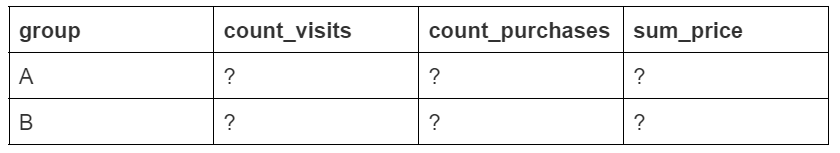
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [64]:
df_1 = updated_data.groupby(by='group')[['user_id']].count()
df_2 = updated_data.groupby(by='group')[['purchase', 'cost']].sum()
df = df_1.join(df_2)
df = df.rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'cost':'sum_price'})
df

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

* Количество посещений по группам практически идентично
* Как и количество совершенных покупок
* На данный момент можно сделать вывод, что **Выборки сбалансированны**

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [ ]:
# ваш код здесь

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [ ]:
# ваш код здесь

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [ ]:
# ваш код здесь

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [ ]:
# ваш код здесь

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [ ]:
# ваш код здесь

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [ ]:
# ваш код здесь

ваши выводы здесь

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 